#Team Information & Contents


|Team-number :| 4|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Altuğ Demirşah|demira02@ads.uni-passau.de|109776|
|Elif Günay| 	guenay01@ads.uni-passau.de|109806|
|Evren Can| can05@ads.uni-passau.de|109484|


**

--------------------------------------------------------------------------------

**

This report is provided for the second-assignment of the Deep Learning and Text Analysis in Finance course at the University of Passau on WiSe 21/22.

**

**Aim**: This report contains our own preprocessing and modelling approaches for a text input that labeled by us on label studio in order to predict its labels.

**

**Contents**:

1. **Import Needed Libraries**

2. **Data Preprocessing**

    2.1. Generate a Dataframe

    2.2. Generate Label

    2.3. Generate Corpus

3. **Topic Modeling**

    3.1. Convert to Document-Term Matrix

    3.2. Convert to Frequency-Inverse Document Frequency Matrix

    3.3. Fit Latent Dirichet Allocation Models


4. **Doc2Vec & Embedding**

    4.1. Doc2Vec

      4.1.2 Why we use Doc2Vec instead of Word2Vec?

    4.2. Embedding

5. **Modeling**

    5.1. Generate Evaluation Metrics and Model Checkpoint

    5.2. Train-Test Split

    5.3. Architecture
    
      5.3.1. Why did we use RNN?

    5.4. Prediction


6. **Comments**

    6.1. Reparding to data preprocessing

    6.2. Regarding to topic modeling

    6.3. Reparding to doc2vec & embedding 

    6.4. Final comments


In order to run this code file, these should be considered:

- This code file was created on Google Colab and data was uploaded from Google Drive.
- Since we run this code file on the basic Colab version, limited memory and computational sources are provided by the platform. Running this code file on a different device might require/take a long time depending on the sources that the device has.

#Import needed libraries

In [ ]:
"""
Needed libraries:

  For data proprocessing:

    pandas: we use pandas library to manipulate data and analyse inside of it. In our case, manipulating numerical tables and time series.
    numpy:  we use numpy since it offers a large collection of high-level mathematical functions to operate on the arrays.
    matplotlib: matplotlib is a plotting library
    sklearn:  to change raw feature vectors into a representation that is more suitable for the downstream estimators

    re -> Regular expression operations
    nltk -> is a suite of libraries and programs for symbolic and statistical natural language processing for English written in the Python programming language.
    gensim -> open-source library for unsupervised topic modeling and natural language processing

    pyLDAvis -> designed to help users interpret the topics in a topic model that has been fit to a corpus of text data

  For modelling:
  
    tensorflow:  used to design, build, and train deep learning models. 
      ->  layers: this is the class from which all layers inherit such as LSTM, GRU, Dense and so on
   
"""

# data preprocessing
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pylab as plt

import re
import string
import nltk
nltk.download('punkt')
from nltk import word_tokenize
import gensim
from gensim.models.doc2vec import Doc2Vec
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA_model

!pip install pyLDAvis
import pyLDAvis        
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


# modelling
import tensorflow as tf
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, GRU, LSTM, Embedding
from keras import backend as K
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


#Connect google drive & load data

In [ ]:
# to download data, first we need to connect to google drive
from google.colab import drive
drive.mount('/gdrive')


# load data
path = '/gdrive/MyDrive/DLTA/Data/tasks3'
with open(path, 'rb') as f:
    tasks = pickle.load(f)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


#Data preprocessing

* Before we do anything, text must be preprocessed. This can be tricky for certain documents, but,  for the moment we will use an easy self-made implementation of some existing functions which will do an effecient progress for the text preprocessing.

* Typical steps of preprocessing include exclusion of punctuation, the transformation to lower case letters, the removal of numbers and more steps such as the removal of stopwords and stemming. For instance;

* Stopwords: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”). We would not want these words to take up space in our dataset, or taking up valuable processing time. Also, when looking for common words in our dataset, finding out that "a" is the most common, is not particularly interesting

* Lemmatising: Lemmatisation (or lemmatization) in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.

    Loved -> love

* Stemming: In linguistic morphology and information retrieval, stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form

    Loved -> lov

##Generate a dataframe

In [ ]:
def generate_df(tasks : list, index : int) -> pd.DataFrame:
  """"
  generate a dataframe in order to keep data clean and work with

  Arg:
    tasks: the dataset
    index: index of annotation between 62, 63, 64
  
  Return:
    pd.DataFrame
  
  """
  
  #############################################################################################################################################
  # code below is taken from Mohammed's post on stud ip

  df = pd.DataFrame(columns=["text", "category", "stage", "level"])

  question_tags = [
        "Question_1_Company_specific", "Question_1_Market_related",
        "Question_2_specific", "Question_2_open", 
        "Question_3_attack", "Question_3_support", "Question_3_neutral"
  ]

  answer_tags = [
        "Answer_1_specific", "Answer_1_avoid_excuse", 
        "Answer_2_negative", "Answer_2_positive", 
        "Answer_3_blame", "Answer_3_no_blame"
  ]

  tag2val = {
        "Question_1_Company_specific": 0,
        "Question_1_Market_related": 1,
        "Question_2_specific": 0,
        "Question_2_open": 1,
        "Question_3_attack": 0,
        "Question_3_support": 1,
        "Question_3_neutral": 2,
        "Answer_1_specific": 0,
        "Answer_1_avoid_excuse": 1,
        "Answer_2_negative": 0,
        "Answer_2_positive": 1,
        "Answer_3_blame": 0,
        "Answer_3_no_blame": 1
  }

  raw_data = tasks[index]

  annotations = raw_data["annotations"][0]["result"]

  for ann in annotations:
            text = ann["value"]["text"]
            label = ann["value"]["labels"][0]
            

            # Ignore any odservation that does not have any of the question and answer stages
            # (ex: an observation that only labels the question QID_13)
            if len(label) < 7:
                continue

            # Get the category "Answer" or "Question" from the label
            category = "Answer" if "Answer" in label else "Question"
            # Get the stage number
            stage = int(label.split("_")[1])
            # Get the level
            level = tag2val[label]
            # Add the observation to the dataframe
            df = df.append(
                {
                    "text": text,
                    "category": category,
                    "stage": stage,
                    "level": level
                },
                ignore_index=True)    

  return df

#############################################################################################################################################

# our earning call ids: 62, 63 and 64 so any of them can be chosen and work with
# since the earling call which is represented with the id of 62 contains more data than the others,
# so we prefered working only with this earning call to focus on data preprocessing and modelling part of NLP, not repating same steps on each earning calls
df = generate_df(tasks, 62)

# check all rows and colomns in df in order to avoid data leakage
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

                                                  text  category stage level
0     I know you don't want to be too specific arou...  Question     1     1
1     I know you don't want to be too specific arou...  Question     2     0
2     I know you don't want to be too specific arou...  Question     3     2
3     what we're seeing in memory is customers cont...    Answer     1     0
4    what we're seeing in memory is customers conti...    Answer     2     1
5    what we're seeing in memory is customers conti...    Answer     3     1
6    If I could sneak in a quick follow-up, like yo...  Question     1     0
7    If I could sneak in a quick follow-up, like yo...  Question     2     0
8    If I could sneak in a quick follow-up, like yo...  Question     3     1
9    the services business is a great growth driver...    Answer     1     0
10   the services business is a great growth driver...    Answer     2     1
11   the services business is a great growth driver...    Answer     3     1

##Generate label

In [ ]:
def choose_label(df : pd.DataFrame, category : str, stage : str) -> pd.DataFrame:
  """
  This function allows us to create a new label dataframe in order to work with chosen category, stage and to avoid text repeating

  Arg:
    df (pd.DataFrame): a dataframe that will be worked on
    category: category that will be picked beetween 'Question' and 'Answer'
    stage: stage that will be picked between 1, 2, 3(only for Question_3)

  Returns:
    pd.DataFrame
  
  """
  

  label_df = df.loc[(df['category'] == category) & (df['stage'] == stage)].reset_index(drop=True)

  return label_df


# any category('Question' or 'Answer') and stage (1,2 or 3(can be chosen only for Question_3)) can be chosen
# since Question_1's distribution is balanced, the same amount of positive and negative samples, we work with that category to maximize the performance
label_df = choose_label(df, 'Question', 1)
label_df

,text,category,stage,level
0,I know you don't want to be too specific arou...,Question,1,1
1,"If I could sneak in a quick follow-up, like yo...",Question,1,0
2,can you talk about the puts and takes between ...,Question,1,0
3,"Gary, you talked quite a bit about your expect...",Question,1,1
4,I think in the past you guys have spoken about...,Question,1,0
5,"If in 2020, if everything else being equal, if...",Question,1,0
6,you guys have done a great job to kind of talk...,Question,1,0
7,"Then as my follow up Gary, just going back to ...",Question,1,1
8,On the better performance in AGS in the Octobe...,Question,1,1
9,And when we think between cost per bit decline...,Question,1,0


## Generate corpus

In [ ]:
def text_preprocessor(text_to_clean: list, remove_stopwords = False, stemming = False) -> list:
    """
    preprocessing a text with applying lower case, removing numbers, puntuations, white spaces and stopwords in order to strength text input

    Arg:
      text_to_clean(list): text inputs that will be preprocessed
      remove_stopwords(bool): True or False, default False
      stemming(bool): process of reducing inflected words to their word stem, base or root form, True or False, default False

    Return:
      preprocessed text
    
    """

    # import a stemmer for english words
    snowStem = nltk.stem.SnowballStemmer('english')
    # lower case
    text_to_clean = text_to_clean.lower()
    # remove numbers 
    text_to_clean = re.sub(r'\d+', '', text_to_clean)
    # remove punctuation
    text_to_clean = text_to_clean.translate(str.maketrans('','', string.punctuation))
    # remove leading and ending white spaces
    text_to_clean = text_to_clean.strip()
    
    if stemming:
      # stemming
      text_to_clean = snowStem.stem(text_to_clean)
    
    if remove_stopwords:
        # remove stop words
        text_to_clean = ' '.join([w for w in text_to_clean.split() if not(w in STOPWORDS)])
    
    return text_to_clean

preprocessed_data = []

for text in label_df['text']:
  preprocessed_data.append(text_preprocessor(text, remove_stopwords=True, stemming=False))

label_df['clean_text'] = preprocessed_data
label_df

,text,category,stage,level,clean_text
0,I know you don't want to be too specific arou...,Question,1,1,know dont want specific timing magnitude recov...
1,"If I could sneak in a quick follow-up, like yo...",Question,1,0,sneak quick followup like said quick second se...
2,can you talk about the puts and takes between ...,Question,1,0,talk puts takes oled lcd kind flattish display...
3,"Gary, you talked quite a bit about your expect...",Question,1,1,gary talked bit expectations new products year...
4,I think in the past you guys have spoken about...,Question,1,0,think past guys spoken data analytics talking ...
5,"If in 2020, if everything else being equal, if...",Question,1,0,equal nand wfe putting numbers expect amat sem...
6,you guys have done a great job to kind of talk...,Question,1,0,guys great job kind talking trends relative de...
7,"Then as my follow up Gary, just going back to ...",Question,1,1,follow gary going comments foundry logic looki...
8,On the better performance in AGS in the Octobe...,Question,1,1,better performance ags october quarter strong ...
9,And when we think between cost per bit decline...,Question,1,0,think cost bit declines memory dram nand rate ...


# Topic Modelling

is an unsupervised machine learning technique that can be applied to process a large number of unlabeled text documents to discover hidden topics.

Common topic modelling algorithms:

 - *Latent Semantic Analysis*(LSA): Matrix decomposition

 - *Latent Dirichlet Allocation*(LDA): probabilistic inference

LSA vs LDA: same input, similar output, different math

 - first step is to convert text into numerical representation such as document term frequency matrix that contains the word count for each word in each document and these words are called term and this matrix is also known as corpus
 
 - with **LSA**, after you apply singular value decomposition(svm) and you obtain two output matrices
 
  - document spesific topic allocation matrix
  - topic spesific word allocation matrix
 
 - with **LDA**, which is a particularly popular method for fitting a topic model, you apply statistical inference to obtain similar output but in the form of probability disturabion 
  
  - given a document what is the probability distibution of each topic with in the document
  
  - given a specific topic what is your word distibution from your vocabulary 

 - ones you have these outputs, important point is such as document similarity and word similarity can be calculated; for example based on the dot product of corresponding rows

## Convert to document-term matrix

In [ ]:
# Convert a collection of text documents to a matrix of token counts

# term frequency vector
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',            # remove accents and perform other character normalization during the preprocessing step
                                stop_words = 'english',               
                                lowercase = True,                     # convert all characters to lowercase before tokenizing
                                token_pattern = r'\b[a-zA-Z]{3,}\b'   # choose the words contain letters, not numbers, chosen words need to have at least three letters
                              )

# document term frequency matrix
dtm_tf = tf_vectorizer.fit_transform(label_df['text'])       # label_df['text'] performs slightly better than label_df['clean_text']
pd.DataFrame(data = dtm_tf.toarray(), columns = tf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acquisition,actually,additional,ags,amat,analytics,answers,applied,area,areas,...,understand,update,utilization,view,walk,want,way,weakens,wfe,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,2,3
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,3
8,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Conver to frequency–inverse document frequency matrix

1. *In Term Frequency(TF)*, you just count the number of words occurred in each document. The main issue with this Term Frequency is that it will give more weight to longer documents. Term frequency is basically the output of the BoW model.

2. *IDF(Inverse Document Frequency)* measures the amount of information a given word provides across the document. IDF is the logarithmically scaled inverse ratio of the number of documents that contain the word and the total number of documents.
$$
* *TF(w)*=*Frequency of w occurs in the document / the total number of words*

* *IDF(w)*=*log(the number of documents containing the term)/ the total number of documents(+1)*


$$
W = log\frac{documents}{W}
$$

* *documents*	=	Number of documents

* *W*	=	Number of documents containing word

$$TF-IDF(w)=TF(w)*IDF(w)$$

3. TF-IDF(Term Frequency-Inverse Document Frequency) normalizes the document term matrix. It is the product of TF and IDF. Word with high tf-idf in a document, it is most of the times occurred in given documents and must be absent in the other documents. 


In [ ]:
# convert a collection of raw documents to a matrix of TF-IDF features

# requency–inverse document frequency vector
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

# document term frequency–inverse document frequency
dtm_tfidf = tfidf_vectorizer.fit_transform(label_df['text'])           # label_df['text'] performs slightly better than label_df['clean_text']
pd.DataFrame(data = dtm_tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:2032: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,acquisition,actually,additional,ags,amat,analytics,answers,applied,area,areas,...,understand,update,utilization,view,walk,want,way,weakens,wfe,year
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.167822,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.188621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.153353,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137551,0.093006
4,0.000000,0.00000,0.000000,0.000000,0.143644,0.164507,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.128842,0.000000,0.000000,0.257685,0.261353
5,0.000000,0.00000,0.000000,0.000000,0.206585,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185297,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.190025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.230493
7,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.122644,0.000000,0.000000,0.000000,0.122644,0.000000,0.194845
8,0.000000,0.00000,0.000000,0.202825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.177103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.150076,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150076,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Fit Latent Dirichet Allocation models

In [ ]:
"""
  n_components: number of topics which we want to mimic the situation which we don't know exactly how many topics are within the documents, default=10
"""

# for TF DTM
lda_tf = LDA_model(n_components=10, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LDA_model(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=0)

In [ ]:
"""
  pyLDAvis is used to visualize modeled results:
    - topic prevalance
    - topic similarity
    - topic interpretation  

   lda_tf: lda object
   dtm_tf: numerical representation
   tf_vectorizer: contains all the word recall vocabulary for us to plot

   1- each topic is represented by circle the area of each circle represents an important quantity which is 
      the topic prevalence, indices here indicate the sorted order by the area

   2- the distance between two circles that represents the topic similarity but it is only an approximation
      to the original topic similarity matrix because we are only using a two dimensional scatter plots
      that reprsend original dimention

   3- red bar term frequency for this particular topic, blue bar is the overall term frequency(appering
      in other topics)

   lambda: helps you to interpret the topic more clearly because it tries to strike a balance between choosing
           only jargons choosing words that are more lament oriented terms 


"""
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
7      32.420952   8.115230       1        1  34.914568
8       0.648955  71.707100       2        1  18.704777
6      71.019684   9.971006       3        1  12.280822
2       3.785981  33.185135       4        1   9.088846
0     -42.666500  -9.222070       5        1   9.074419
4      -3.621689 -43.526516       6        1   8.230877
3      -3.632402  -4.171708       7        1   6.870401
1     -36.584400  35.804413       8        1   0.278430
5      44.391380  50.615383       9        1   0.278430
9      40.235809 -31.591665      10        1   0.278430, topic_info=            Term       Freq      Total Category  logprob  loglift
298         year  15.000000  15.000000  Default  30.0000  30.0000
160         nand   5.000000   5.000000  Default  29.0000  29.0000
209      quarter   8.000000   8.000000  Default  28.0000  28.0000
138         like   6.000000   6.000000  Default  27.0000  27.0000
85       foundry   9.000000   9.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
138         like   0.005513   6.084250  Topic10  -5.7004  -1.1226
30         china   0.005513   2.837966  Topic10  -5.7004  -0.3600
19           bit   0.005513   3.561011  Topic10  -5.7004  -0.5870
279     thinking   0.005513   2.000301  Topic10  -5.7004  -0.0102
119  incremental   0.005513   3.508795  Topic10  -5.7004  -0.5722

[499 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         5  0.421040  acquisition
0         6  0.421040  acquisition
2         2  0.781261   additional
3         3  0.829076          ags
4         4  0.559471         amat
...     ...       ...          ...
298       1  0.578555         year
298       2  0.064284         year
298       3  0.064284         year
298       4  0.128568         year
298       7  0.128568         year

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 7, 3, 1, 5, 4, 2, 6, 10])

#Doc2Vec & Embedding

##**Doc2vec**
The straightforward approach of averaging each of a text's words' word-vectors creates a quick and crude document-vector that can often be useful.

**The basic idea is**: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector.

Gensim's Doc2Vec class implements this algorithm.

### Why we use Doc2Vec instead of Word2Vec?
In text analysis, we usually get information from whole documents, not from single words.
For example, the word "apple" does not provide any useful information for us. However, "The apples in Netto taste delicious." means something.

Therefore, we used Doc2Vec approach in our example, since we use Question and Answer labels in similar formats.

In [ ]:
sentences = [text.split() for text in label_df['clean_text']]
len(sentences)

tagged_documents = []

for i, doc in enumerate(sentences):
  tagged_documents.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))


d2v = Doc2Vec(vector_size=60, epochs=30)
d2v.build_vocab(tagged_documents)

d2v.train(tagged_documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

doc_vecs = [d2v.infer_vector(tag_doc.words) for tag_doc in tagged_documents]

# check dimension of doc_vecs before feeding it into the model
print(f'dimension of doc_vecs: ({len(doc_vecs)},{len(doc_vecs[0])})')

dimension of doc_vecs: (17,60)


## Embedding

In Doc2Vec, first we create a one-hot matrix by using the words in the document, and with input vector we create our matrix that represents the document in **numeric format**.
First, we need a data structure that will work like a dictionary. There will be the words we have and their numerical equivalents next to them. 

For this porpuse, we used **Tokenizer**. Two more additional id numbers are necessary. These are:

-0 = *null values in the matrix because of zero padding*

-1 = *Out of vocubulary words, oov_token*

In [ ]:
def tokenizer(text_data:pd.DataFrame, oov_token:str) -> np.ndarray:
  """
  Convert text into token ids, later text to sequences and finally apply padding sequences to get the same length

  Arg:
    text_data(pd.DataFrame): corpus
    oov_token(str): it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

  Return:
    embedded matrix
  
  """
  my_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
  my_tokenizer.fit_on_texts(label_df['clean_text'])
  # number of lexicon + 1('NAN')
  print(f'len of tokenizer: {len(my_tokenizer.word_index.keys())}')


  txt_sequences = my_tokenizer.texts_to_sequences(label_df['clean_text'])
  print(f'len of txt sequences {len(txt_sequences)}')


  # better to put zeros in the beginning if you use rnn
  pad_txt_sequences = tf.keras.preprocessing.sequence.pad_sequences(txt_sequences, maxlen=60)
  print(f'len of pad txt sequences: {pad_txt_sequences.shape}')
  """
    We synchronized the dimensions of the documents by zero-padding just above. 
    However, because some sentences were too long compared to others, many documents were filled with so many 0s. 
    We set maxlen to get rid of these very long 0 sequences. 
    Considering the length of the text sequences, we decided that maxlen = 60 is a balanced number.
  
  """


  return my_tokenizer, pad_txt_sequences


my_tokenizer, pad_txt_sequences = tokenizer(label_df['clean_text'], 'NAN')
pad_txt_sequences

len of tokenizer: 312
len of txt sequences 17
len of pad txt sequences: (17, 60)


array([[  0,   0,   0, ...,  22,  20,  70],
       [  0,   0,   0, ...,   8, 130,  77],
       [  0,   0,   0, ..., 144,  42, 145],
       ...,
       [  0,   0,   0, ...,   2,   8, 285],
       [  0,   0,   0, ..., 106,   3,   6],
       [  0,   0,   0, ..., 310, 311, 312]], dtype=int32)

# Modeling

## Generate evaluation metrics and model checkpoint

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


"""
  callbacks are the special utilities or functions that are executed during training at given stages of the training procedure. 
  Callbacks can help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs, create a TensorBoard, etc. 
"""

checkpoint_name = 'trained_models/Weights-e{epoch:03d}--v_loss_{val_loss:.5f}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, mode ='min')
callbacks_list = [checkpoint]

## Train test split

In [ ]:
# convert list data into np array
target = np.array(label_df['level'], dtype=np.float32)
doc_vecs = np.array(doc_vecs, dtype=np.float32)

"""
The train-test split is a technique for evaluating the performance of a machine learning algorithm.

It can be used for classification or regression problems and can be used for any supervised learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. 
The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. 
This second dataset is referred to as the test dataset.

  - Train Dataset: Used to fit the machine learning model.
  - Test Dataset: Used to evaluate the fit machine learning model.
"""

# pad_txt_sequences is represented with pts
x_train_pts, x_test_pts, y_train_pts, y_test_pts = train_test_split(pad_txt_sequences,target, test_size=0.2, random_state=42, shuffle=True)

# doc_vecs is represented with dv
x_train_dv, x_test_dv, y_train_dv, y_test_dv = train_test_split(doc_vecs, target, test_size=0.2, random_state=42, shuffle=True)

# let's check if the data separated from the same index before we evaluate doc2vec and embeddings performances
y_train_pts, y_train_dv, y_test_pts, y_test_dv

(array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.], dtype=float32),
 array([1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 1.], dtype=float32))

## Architecture

In [ ]:
pts_model = tf.keras.Sequential([
                                tf.keras.layers.Embedding(input_dim=(len(my_tokenizer.word_index.keys()) + 1), 
                                                          output_dim=150, input_length=60), # Combining the embedding layer
                                tf.keras.layers.GRU(10, return_sequences=True, activation='relu'), # Usage of Recurrent layer
                                tf.keras.layers.GRU(5, activation='relu'), 
                                tf.keras.layers.Dense(1,activation='sigmoid') # Lastly, we add another layer in here with activation function sigmoid
])

pts_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 150)           46950     
                                                                 
 gru (GRU)                   (None, 60, 10)            4860      
                                                                 
 gru_1 (GRU)                 (None, 5)                 255       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 52,071
Trainable params: 52,071
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pts_model.compile(loss='bce', metrics=['accuracy', f1_m,precision_m, recall_m])

# for pad_txt_sequences input
pts_history = pts_model.fit(x_train_pts, y_train_pts, epochs=20, validation_split=0.1, shuffle=True, callbacks = callbacks_list)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.5455 - f1_m: 0.4444 - precision_m: 0.5000 - recall_m: 0.4000
Epoch 1: saving model to trained_models/Weights-e001--v_loss_0.69651.hdf5
1/1 [==============================] - 9s 9s/step - loss: 0.6936 - accuracy: 0.5455 - f1_m: 0.4444 - precision_m: 0.5000 - recall_m: 0.4000 - val_loss: 0.6965 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.9091 - f1_m: 0.8889 - precision_m: 1.0000 - recall_m: 0.8000
Epoch 2: saving model to trained_models/Weights-e002--v_loss_0.69930.hdf5
1/1 [==============================] - 0s 181ms/step - loss: 0.6785 - accuracy: 0.9091 - f1_m: 0.8889 - precision_m: 1.0000 - recall_m: 0.8000 - val_loss: 0.6993 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
1/1 [=============

In [ ]:
dv_model = tf.keras.Sequential([
                                tf.keras.layers.Embedding(input_dim=(len(my_tokenizer.word_index.keys()) + 1), 
                                                          output_dim=150, input_length=60), # Combining the embedding layer
                                tf.keras.layers.GRU(10, return_sequences=True, activation='relu'), # Usage of Recurrent layer
                                tf.keras.layers.GRU(5, activation='relu'),
                                tf.keras.layers.Dense(1,activation='sigmoid') # Lastly, we add another layer in here with activation function sigmoid
])

dv_model.compile(loss='bce', metrics=['accuracy', f1_m,precision_m, recall_m])

# for doc_vecs input
dv_history = dv_model.fit(x_train_dv, y_train_dv, epochs=20, validation_split=0.1, shuffle=True, callbacks = callbacks_list)

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5455 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 1: saving model to trained_models/Weights-e001--v_loss_0.69352.hdf5
1/1 [==============================] - 8s 8s/step - loss: 0.6921 - accuracy: 0.5455 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6935 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5455 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2: saving model to trained_models/Weights-e002--v_loss_0.69387.hdf5
1/1 [==============================] - 0s 169ms/step - loss: 0.6910 - accuracy: 0.5455 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.6939 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_re

### **Why did we use RNN?**

We stated our input is word sequences in Doc2Vec. For this reason, it is possible to say that our work is very similar to timeseries-based deep learning problems.
Instead of time intervals, words are sorted.

For this reason, we applied a model with **Recurrent Neural Network**, which is one of the first solutions that comes to mind in deep learning problems with long sequences.

Although we ran the model with **GRU**, LSTM or regular RNN approaches could also be chosen.

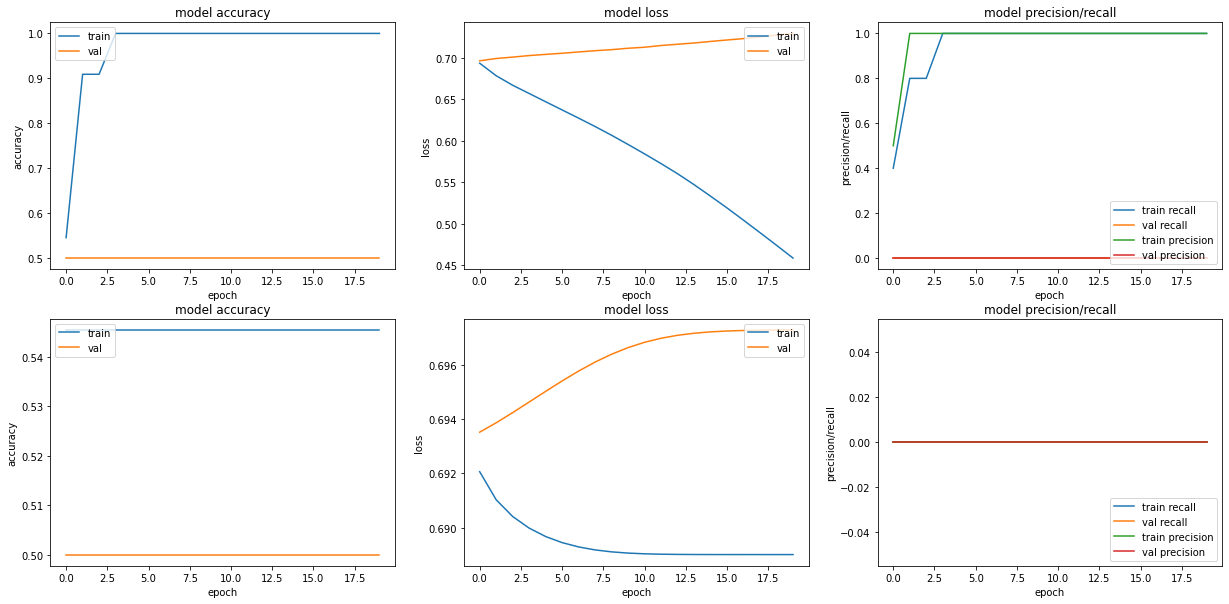

In [ ]:
fig = plt.figure(figsize=(21,10))

plt.subplot(2,3,1)
# summarize history for accuracy
plt.plot(pts_history.history['accuracy'])
plt.plot(pts_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()


plt.subplot(2,3,2)
# summarize history for loss
plt.plot(pts_history.history['loss'])
plt.plot(pts_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(2,3,3)
# summarize history for precision/recall
plt.plot(pts_history.history['recall_m'], label="train recall")
plt.plot(pts_history.history['val_recall_m'], label="val recall")
plt.plot(pts_history.history['precision_m'], label="train precision")
plt.plot(pts_history.history['val_precision_m'], label="val precision")
plt.title('model precision/recall')
plt.ylabel('precision/recall')
plt.xlabel('epoch')
plt.legend(loc='lower right')

####################################################################################################################################
print('\n\n\n\n')
####################################################################################################################################

plt.subplot(2,3,4)
# summarize history for accuracy
plt.plot(dv_history.history['accuracy'])
plt.plot(dv_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.show()


plt.subplot(2,3,5)
# summarize history for loss
plt.plot(dv_history.history['loss'])
plt.plot(dv_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(2,3,6)
# summarize history for precision/recall
plt.plot(dv_history.history['recall_m'], label="train recall")
plt.plot(dv_history.history['val_recall_m'], label="val recall")
plt.plot(dv_history.history['precision_m'], label="train precision")
plt.plot(dv_history.history['val_precision_m'], label="val precision")
plt.title('model precision/recall')
plt.ylabel('precision/recall')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Prediction

In [ ]:
# prediction on test_pts
pts_model.predict(x_test_pts), y_test_pts

(array([[0.4235664 ],
        [0.47960448],
        [0.38275796],
        [0.40072978]], dtype=float32), array([1., 0., 0., 1.], dtype=float32))

In [ ]:
# prediction on all pad_txt_sequences
pts_model.predict(pad_txt_sequences), target

(array([[0.4235664 ],
        [0.47960448],
        [0.2513317 ],
        [0.44043738],
        [0.35384014],
        [0.38275796],
        [0.47219223],
        [0.551576  ],
        [0.5537416 ],
        [0.28070074],
        [0.2640342 ],
        [0.57914233],
        [0.2899829 ],
        [0.5729519 ],
        [0.57209957],
        [0.40072978],
        [0.27548116]], dtype=float32),
 array([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       dtype=float32))

In [ ]:
# prediction on a
dv_model.predict(x_test_dv), y_test_dv

(array([[0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603]], dtype=float32), array([1., 0., 0., 1.], dtype=float32))

In [ ]:
# predict on all doc_vecs
dv_model.predict(doc_vecs), target

(array([[0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603],
        [0.4545603]], dtype=float32),
 array([1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       dtype=float32))

#Comments

##Regarding to data preprocessing

There are many great NLP libraries out to implement to our projects. To get familiar with some of them, we tried to use several of them as NLTK, Gensim, re and more. Also, sklearn provides text preprocessing in some of its functions as we used in CountVectorizer, TfidfVectorizer and they performed slightly better than the manual approach we did.


## Regarding to topic modeling
Topic modelling was a nice challenge for us. We thought working with LDA would be more interesting to discover the topics from the financial textual data. Also, visualization of the topics with pyLDAvis was helping us to understand it better. Additionally, we chose the number of components as 10 because we did not understand clearly how to pick it with the best way which is why we decided to keep it as default since we were dealing with a small amount of textual data.

## Reparding to doc2vec & embedding

Since we were dealing with text data that is sequential, we thought that implementing doc2vec might be smarter than working with word2vec since it is easier to focus on the semantic understanding of the text. Also, we took the vector_size as 60 because of the dimension of the embedded vector in order to compare them equally.


## Regarding to modelling

Rather than focusing on the model architecture, we wanted to focus on how doc2vec and embedded vectors perform on the same model. As we have experienced, in our case embedded vectors are better to get a better semantic understanding from our textual data compare to doc2vec vectors as we can see on the predictions. 

## Final comments

This notebook describes our own approaches to textual analysis assignment, which served as the second sub-assignment for the Deep Learning and Text Analysis in Finance course at the University of Passau.

For this purpose, we applied different methods such as frequency, topic modelling, word embedding and more.

Nevertheless, it was a great experience and a nice discovery of the text analysing world where lots of exciting new discoveries happening in recent years.